In [1]:
import xarray as xr
import numpy as np
from os.path import join
import matplotlib.pyplot as plt
import matplotlib as mpl
import cmocean
from glob import glob
import pandas as pd
from copy import deepcopy
import gsw
import gen_utils
import seaborn as sns
sns.set()

to-do
- How to pick thermocline?
    - plot vertical gradient of potential density (super-impose on $\theta$ or $\rho$ contours)
    - try a bunch of different thermoclines

In [2]:
def velocity_xr(u_vals, v_vals):
    '''Put velocity values in xarray dataarray'''
    # Put on correct grid    
    velocity = xr.DataArray(np.stack([u_vals,v_vals],axis=0), 
                            coords={'name':['u','v'], 'p'   :uv['DepthCenterCell'].values,
                                    'dist':uv['DistanceCenterCell'].values/1000, # convert to km
                                    'time':data.time[::-1]}, dims=['name','time','p','dist'])
    velocity['p'] = -gsw.z_from_p(velocity['p'], lat=40.3) # convert pressure to depth
    velocity      = velocity.rename({'p':'depth'})
    velocity      = velocity.reindex(time=velocity.time[::-1]) # time dimension matches density data
    velocity      = velocity.interp({'dist':data.dist}) # interpolate distances to match density data
    return velocity

def get_ym(data, idx):
    '''Get year and month from the data, given data and index'''
    time = data.time.isel(time=idx)
    y    = time.dt.year.values.item()
    m    = time.dt.month.values.item()
    return y, m

def get_lower_upper(data, iso):
    '''Get quantity averaged over lower and upper layers of the 1.5 layer model'''
    lower_list, upper_list = [], []
    for d in data.dist:
        boundary  = iso.sel(dist=d).values.item() 
        lower = data.sel(dist=d, depth=slice(boundary,None))
        upper = data.sel(dist=d, depth=slice(None,boundary))
        lower, upper = [x.mean('depth').values.item() for x in [lower, upper]]
        lower_list.append(lower)
        upper_list.append(upper)
    return np.array(lower_list), np.array(upper_list)

def get_iso_np(data, x):
    '''Given a dataset and the value of an isopycnal/therm, get coordinates of isopycnal/therm'''
    levels = np.array([x])
    idx = np.where(levels==x)[0].item()
    p = plt.contour(data['dist'], data['depth'], data.T, levels=levels)
    plt.close()
    c = p.allsegs[idx][np.argmax([len(y) for y in p.allsegs[idx]])]
    return c

def get_iso_xr(iso):
    '''Convert isoline to xarray'''
    iso = xr.DataArray(iso[:,1], coords={'dist':pd.Index(iso[:,0])}, dims=['dist'])
    iso = iso.drop_duplicates('dist').interp(dist=data['dist'])
    return iso

def get_iso(data,x):
    '''Combines get_iso_xr and get_iso_np'''
    return get_iso_xr(get_iso_np(data,x))

def get_xgrad(iso):
    '''Compute horizontal gradient of the isoline'''
    return iso.differentiate('dist') / 1000 # convert from km to m

def get_gprime(rho, iso):
    '''Compute reduced gravity, based on isotherm/isopycnal'''
    g = 9.8
    rho_lower, rho_upper = get_lower_upper(rho, iso)
    gprime = deepcopy(iso)
    gprime.values = g * (rho_lower-rho_upper) / (rho_upper + 1000) #
    return gprime

def est_velocity(rho, iso):
    '''Get estimated velocity from data, based on selected iso-line'''
    # Compute coriolis parameter
    omega  = 2*np.pi/(3600*24) # rotation rate of earth (radians/sec)
    f      = 2*omega*np.sin(np.deg2rad(40.3)) # estimate of f0, based on latitude of ~40 degrees N
    
    # Compute horizontal gradient and reduced gravity
    grad   = get_xgrad(iso)
    gprime = get_gprime(rho, iso) # Compute reduced gravity
    v      = gprime / f * grad    # velocity
    return v

# Load data

## Density

In [3]:
data  = xr.open_dataset('ctd-data.nc')
data['p'] = -gsw.z_from_p(data['p'], lat=40.3)
data = data.rename({'p':'depth'})

## Velocity
For transformed coordinate system, use projection array computed in ```lab2_load-data.ipynb```

In [4]:
## ADCP velocities
uv = xr.open_dataset('VelocityData.nc')

###### Transformed velocity ######
# Projection matrix
P = np.array([[ 0.44254196, -0.8967478 ],
              [ 0.8967478 ,  0.44254196]])
uv = xr.open_dataset('VelocityData.nc')
u  = uv['AllUArray'].values
v  = uv['AllVArray'].values

# Get transformed velocities
uv_stack = np.stack([u,v],axis=0)
uvhat      = (P @ uv_stack.reshape(2,-1)).reshape(uv_stack.shape)
vhat_adcp = velocity_xr(uvhat[0], uvhat[1])

###### Speed ###########
v_     = np.sqrt(uv['AllUArray']**2 + uv['AllVArray']**2).values
u_     = 0 * deepcopy(v)
speed_adcp = velocity_xr(u_,v_)

# Theoretical velocity

Compute geostrophic velocity based on "reduced gravity'' equations:  
$fv = g\nabla \eta_1$  
$\implies v = \frac{g}{f}\frac{\partial\eta_1}{\partial x}$

In [5]:
mpl.rcParams['figure.dpi'] = 200

time_idx      = 1
iso_level     = 26.5
name          = 'rho' # one of {'T','rho'}
name_plot     = 'rho' # which variable to contour on the plots...
plot_velocity = False

## Compute isoline and velocity
data_ = data.isel(time=time_idx)          # get correct timestep
rho_  = data['rho'].isel(time=time_idx)   # density
iso   = get_iso(data_[name], x=iso_level) # compute depth of isoline
vhat  = est_velocity(rho_, iso)           # estimate velocity

# Partition ADCP data by layer
vhat_adcp_lo, vhat_adcp_hi = get_lower_upper(vhat_adcp.sel(name='v').isel(time=time_idx), iso)
s_adcp_lo, s_adcp_hi       = get_lower_upper(speed_adcp.sel(name='v').isel(time=time_idx), iso)

### Integrated transport 
'''Note: taking the mean is not good enough!!!! e.g. if velocity varies non-lienarly with depth'''
vhat_transport      = vhat          * iso # integrated transport (note: units of iso are 'm')
vhat_adcp_transport = vhat_adcp_hi  * iso
s_adcp_tranport     = s_adcp_hi     * iso

## Plot version 2
Velocity colors, isothermal/pycnals contoured, with selected isopycnal highlighted

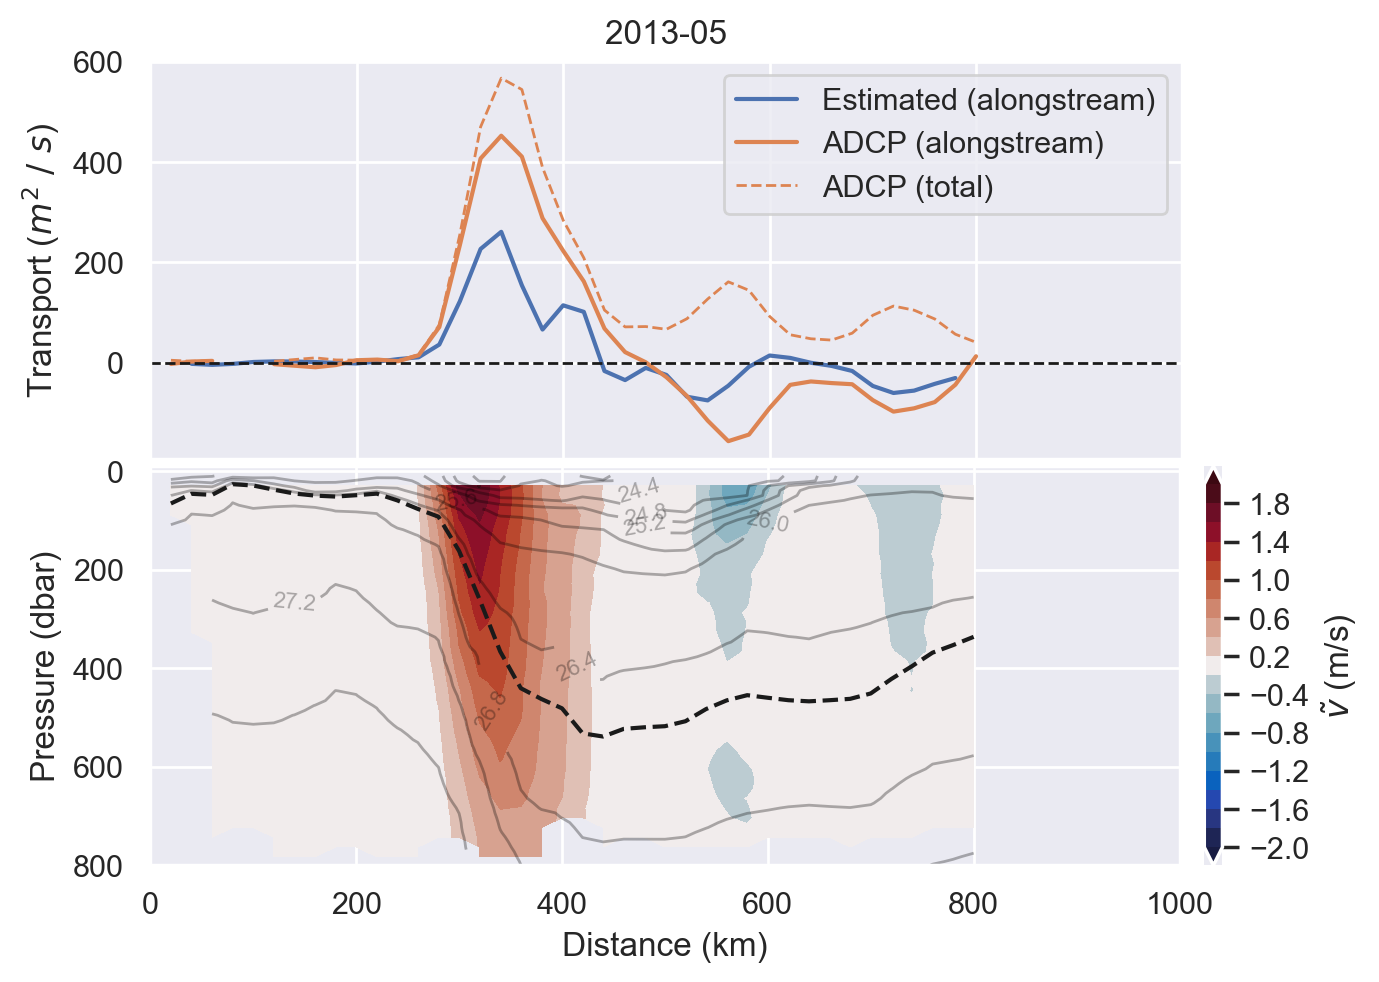

In [6]:
##### Plotting 
c = sns.color_palette()
figsize = np.array([8,16/3])
fig = plt.figure(figsize=figsize)
gs = fig.add_gridspec(20,30)

#### Land vs. Ocean #####
ax0 = fig.add_subplot(gs[:10,:25])
if plot_velocity:
    p1 = ax0.plot(vhat.dist, vhat.values,  label='Estimated (alongstream)')
    p2 = ax0.plot(vhat.dist, vhat_adcp_hi, color=c[1], label='ADCP (alongstream)')
    p2 = ax0.plot(vhat.dist, s_adcp_hi,    color=c[1], label='ADCP (total)', ls='--', lw=1)
    ax0.set_ylabel('Velocity ($m~/~s$)')
else:
    p1 = ax0.plot(vhat.dist, vhat_transport.values,          label='Estimated (alongstream)')
    p2 = ax0.plot(vhat.dist, vhat_adcp_transport,  color=c[1], label='ADCP (alongstream)')
    p2 = ax0.plot(vhat.dist, s_adcp_tranport,      color=c[1], label='ADCP (total)', ls='--', lw=1)
    ax0.set_ylabel(r'Transport ($m^2~/~s$)')
ax0.set_xticklabels([])
ax0.axhline(0,ls='--',lw=1,c='k')
ax0.set_xlim([0,1000])
ax0.legend()
y,m = get_ym(data, time_idx)
ax0.set_title(f'{y}-{m:02d}')

#### Plot Velocity profile ####
ax = fig.add_subplot(gs[10:,:])
p = ax.contourf(vhat_adcp.dist, vhat_adcp.depth, vhat_adcp.sel(name='v').isel(time=time_idx), 
                cmap='cmo.balance', levels=gen_utils.make_cb_range(2,.2), extend='both')
cb = fig.colorbar(p, orientation='vertical', label=r'$\tilde{v}$ (m/s)', pad=.02)

# Iso-lines (temperature or density)
data_plot = data.isel(time=time_idx)[name_plot].T
levels    = np.arange(0,25,2) if name_plot=='T' else 12
p = ax.contour(data.dist, data.depth, data_plot, colors='black', linewidths=1,
               levels=levels, extend='both', alpha=.3) # create contour plot
ax.clabel(p, fontsize=8)

ax.plot(iso.dist, iso.values, c='k', ls='--')
ax.set_ylabel('Pressure (dbar)')
ax.set_xlabel('Distance (km)')
ax.set_ylim([-10,800])
plt.gca().invert_yaxis() # reverse order of y axis so that depth decreases going down

plt.show()

## Plot version 1

AttributeError: 'numpy.ndarray' object has no attribute 'dist'

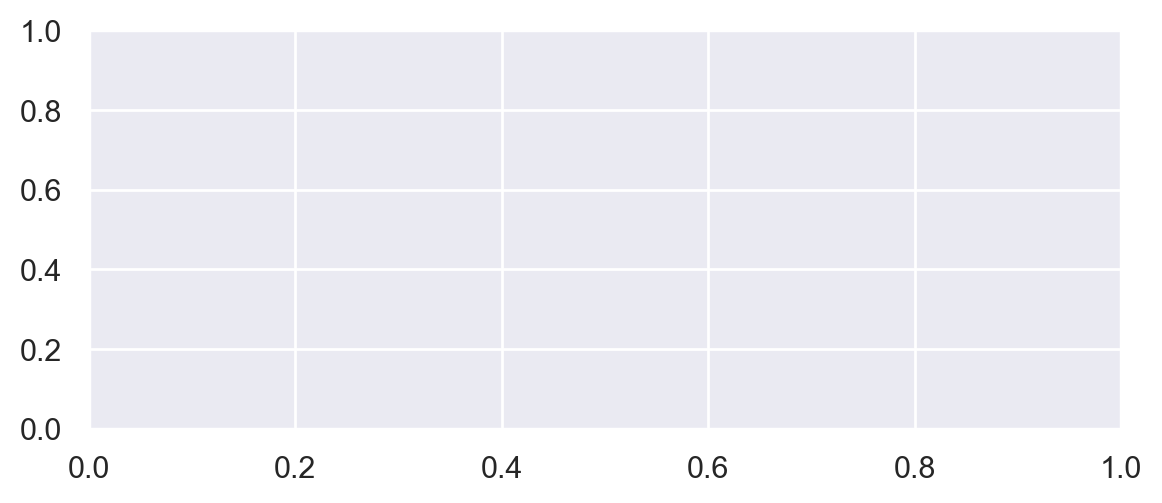

In [7]:
##### Plotting 
c = sns.color_palette()
figsize = np.array([8,8])
fig = plt.figure(figsize=figsize)
gs = fig.add_gridspec(30,30)

#### Land vs. Ocean #####
ax0 = fig.add_subplot(gs[:10,:25])
if plot_velocity:
    p1 = ax0.plot(v.dist, v.values, label='Estimated')
    p2 = ax0.plot(v.dist, vhat_upper,  color=c[1], label='Alongstream velocity')
    p2 = ax0.plot(v.dist, speed_upper, color=c[1], label='Speed', ls='--', lw=1)
    ax0.set_ylabel('Velocity ($m~/~s$)')
else:
    p1 = ax0.plot(v.dist, v_transport.values, label='Estimated')
    p2 = ax0.plot(v.dist, vhat_transport,  color=c[1], label='Alongstream velocity')
    p2 = ax0.plot(v.dist, speed_tranport, color=c[1], label='Speed', ls='--', lw=1)
    ax0.set_ylabel(r'Transport ($m^2~/~s$)')
ax0.set_xticklabels([])
ax0.axhline(0,ls='--',lw=1,c='k')
ax0.set_xlim([0,1000])
ax0.legend()
y,m = get_ym(data, time_idx)
ax0.set_title(f'{y}-{m:02d}')

#### Plot Temperature profile ###
ax = fig.add_subplot(gs[10:20,:])
p = ax.contourf(data.dist, data.depth, data.isel(time=time_idx)['T'].T, cmap='cmo.thermal',
               levels=np.arange(0,25,2), extend='both') # create contour plot
cb = fig.colorbar(p, orientation='vertical', pad=.02, label=r'$\theta$ (K)')
ax.plot(iso.dist, iso.values, c='k', ls='--')
ax.set_ylabel('Pressure (dbar)')
ax.set_xticklabels([])
ax.set_ylim([-10,1000])
plt.gca().invert_yaxis() # reverse order of y axis so that depth decreases going down

#### Plot Velocity profile ####
ax = fig.add_subplot(gs[20:30,:])
p = ax.contourf(velocity.dist, velocity.depth, velocity_transformed.sel(name='v').isel(time=time_idx), 
                cmap='cmo.balance', levels=gen_utils.make_cb_range(2,.2), extend='both')
cb = fig.colorbar(p, orientation='vertical', label=r'$\tilde{v}$ (m/s)', pad=.02)
ax.plot(iso.dist, iso.values, c='k', ls='--')
ax.set_ylabel('Pressure (dbar)')
ax.set_xlabel('Distance (km)')
ax.set_ylim([-10,800])
plt.gca().invert_yaxis() # reverse order of y axis so that depth decreases going down

plt.show()

Compare:
- accuracy with different isotherms/isopycnals
- using potential density vs. potential temperature

# Plot

## Density

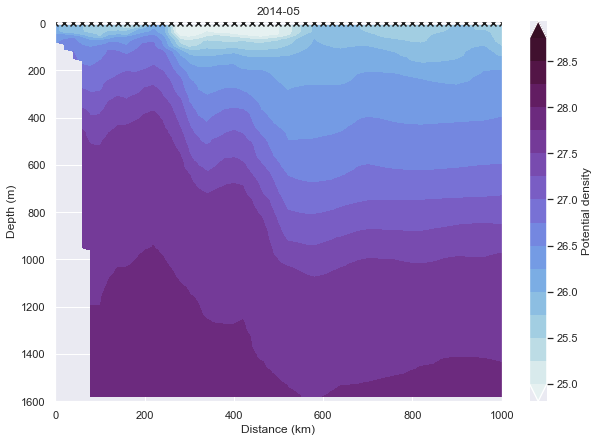

In [4]:
i = 0 # time index to plot
fig, ax = plt.subplots(figsize=(10,7)) # create canvas for plotting
p = ax.contourf(data.dist, data.depth, data.isel(time=i)['rho'].T, cmap='cmo.dense',
               levels=np.arange(25,29,.25), extend='both') # create contour plot
ax.scatter(data.dist, np.zeros(len(data.dist)),marker='x', color='k')
cb = fig.colorbar(p, orientation='vertical', label=r'Potential density') # create colorbar
ax.set_ylabel('Depth (m)')
ax.set_xlabel('Distance (km)')
ax.set_ylim([-10,1600])
time = data.time.isel(time=i)
y    = time.dt.year.values.item()
m    = time.dt.month.values.item()
ax.set_title(f'{y}-{m:02d}')
plt.gca().invert_yaxis() # reverse order of y axis so that depth decreases going down
plt.show()

## Temperature

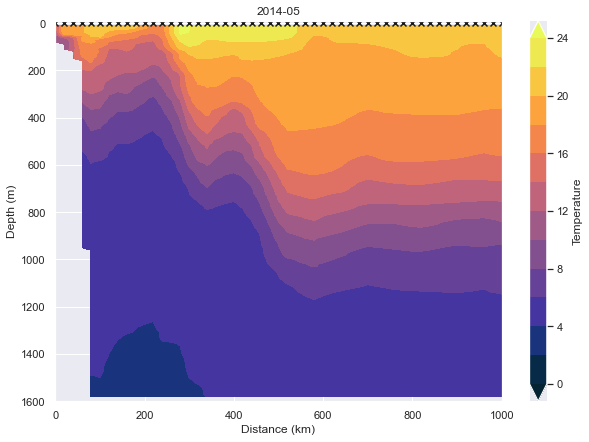

In [5]:
i = 0 # time index to plot
fig, ax = plt.subplots(figsize=(10,7)) # create canvas for plotting
p = ax.contourf(data.dist, data.depth, data.isel(time=i)['T'].T, cmap='cmo.thermal',
               levels=np.arange(0,25,2), extend='both') # create contour plot
ax.scatter(data.dist, np.zeros(len(data.dist)),marker='x', color='k')
cb = fig.colorbar(p, orientation='vertical', label=r'Temperature') # create colorbar
ax.set_ylabel('Depth (m)')
ax.set_xlabel('Distance (km)')
ax.set_ylim([-10,1600])
time = data.time.isel(time=i)
y    = time.dt.year.values.item()
m    = time.dt.month.values.item()
ax.set_title(f'{y}-{m:02d}')
plt.gca().invert_yaxis() # reverse order of y axis so that depth decreases going down
plt.show()